Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [2]:
passengers = df['Passengers'].values.astype(np.float32)
print(type(passengers))
print(passengers[:5])
print(passengers.dtype)

<class 'numpy.ndarray'>
[112. 118. 132. 129. 121.]
float32


Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [3]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(passengers, test_size=0.33, shuffle=False)
print("train size", len(train))
print("val size", len(val))

train size 96
val size 48


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [4]:
import torch

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:i + lookback])
        y.append(dataset[i + lookback])
    X = torch.tensor(X).unsqueeze(-1)  
    y = torch.tensor(y).unsqueeze(-1)  
    return X, y


In [5]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(val, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1])


/tmp/ipykernel_71821/1185838113.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X).unsqueeze(-1)


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [6]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AirModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=1,
                           batch_first=True
                          )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out        

In [7]:
model = AirModel(input_size=1, hidden_size=50, num_layers=1)
sample_input = torch.tensor([[[112.]]])
output = model(sample_input)
print(output)

tensor([[0.0334]], grad_fn=<AddmmBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [8]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train, y_train)
batch_size = 8
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

[tensor([[[135.]],
 
         [[184.]],
 
         [[229.]],
 
         [[277.]],
 
         [[242.]],
 
         [[135.]],
 
         [[194.]],
 
         [[235.]]]),
 tensor([[125.],
         [162.],
         [243.],
         [317.],
         [209.],
         [148.],
         [196.],
         [229.]])]

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [11]:
from tqdm import tqdm


def rmse(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2)).item()

def train_model(model, train_dl, test_dl, optimizer, num_epochs=2000, print_every=100):
    criterion = nn.MSELoss()
    losses = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        batch_losses = []

        for xb, yb in train_dl:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)

        if epoch % print_every == 0:
            model.eval()
            with torch.no_grad():
                # Обчислення RMSE на train
                train_preds, train_targets = [], []
                for xb, yb in train_dl:
                    pred = model(xb)
                    train_preds.append(pred)
                    train_targets.append(yb)
                train_preds = torch.cat(train_preds)
                train_targets = torch.cat(train_targets)
                train_rmse = rmse(train_preds, train_targets)

                # Обчислення RMSE на test
                test_preds, test_targets = [], []
                for xb, yb in test_dl:
                    pred = model(xb)
                    test_preds.append(pred)
                    test_targets.append(yb)
                test_preds = torch.cat(test_preds)
                test_targets = torch.cat(test_targets)
                test_rmse = rmse(test_preds, test_targets)

                print(f'Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}')
    
    return losses

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)
losses = train_model(model, train_dl, test_dl, optimizer, num_epochs=2000)

  1%|▏                                        | 11/2000 [00:00<00:37, 53.39it/s]

Epoch 0: train RMSE 223.2507, test RMSE 419.5658


  5%|██▏                                     | 109/2000 [00:01<00:31, 60.49it/s]

Epoch 100: train RMSE 77.9903, test RMSE 245.1905


 10%|████▏                                   | 210/2000 [00:03<00:30, 59.20it/s]

Epoch 200: train RMSE 75.1848, test RMSE 237.9493


 16%|██████▏                                 | 312/2000 [00:05<00:27, 60.43it/s]

Epoch 300: train RMSE 71.4366, test RMSE 221.0939


 20%|████████▏                               | 409/2000 [00:06<00:26, 60.16it/s]

Epoch 400: train RMSE 71.1492, test RMSE 215.2320


 26%|██████████▏                             | 512/2000 [00:08<00:24, 59.73it/s]

Epoch 500: train RMSE 71.1491, test RMSE 215.1265


 30%|████████████▏                           | 608/2000 [00:10<00:27, 51.52it/s]

Epoch 600: train RMSE 71.1492, test RMSE 214.9718


 35%|██████████████▏                         | 709/2000 [00:12<00:24, 53.38it/s]

Epoch 700: train RMSE 71.1494, test RMSE 215.2886


 40%|████████████████▏                       | 807/2000 [00:14<00:19, 60.32it/s]

Epoch 800: train RMSE 71.1496, test RMSE 214.8527


 46%|██████████████████▏                     | 912/2000 [00:15<00:18, 59.95it/s]

Epoch 900: train RMSE 71.1496, test RMSE 214.8674


 51%|███████████████████▋                   | 1011/2000 [00:17<00:17, 56.40it/s]

Epoch 1000: train RMSE 71.1492, test RMSE 215.2053


 56%|█████████████████████▋                 | 1113/2000 [00:19<00:14, 60.78it/s]

Epoch 1100: train RMSE 71.1492, test RMSE 214.9712


 61%|███████████████████████▌               | 1211/2000 [00:20<00:12, 60.84it/s]

Epoch 1200: train RMSE 71.1494, test RMSE 215.2893


 65%|█████████████████████████▌             | 1308/2000 [00:22<00:12, 53.31it/s]

Epoch 1300: train RMSE 71.1502, test RMSE 215.4730


 70%|███████████████████████████▍           | 1407/2000 [00:24<00:12, 48.59it/s]

Epoch 1400: train RMSE 71.1491, test RMSE 215.0712


 75%|█████████████████████████████▍         | 1507/2000 [00:26<00:10, 49.13it/s]

Epoch 1500: train RMSE 71.1491, test RMSE 215.1172


 80%|███████████████████████████████▎       | 1606/2000 [00:28<00:09, 39.44it/s]

Epoch 1600: train RMSE 71.1491, test RMSE 215.1067


 85%|█████████████████████████████████▎     | 1708/2000 [00:31<00:07, 40.77it/s]

Epoch 1700: train RMSE 71.1491, test RMSE 215.0285


 90%|███████████████████████████████████▎   | 1808/2000 [00:33<00:03, 50.62it/s]

Epoch 1800: train RMSE 71.1491, test RMSE 215.1501


 96%|█████████████████████████████████████▏ | 1910/2000 [00:35<00:01, 50.09it/s]

Epoch 1900: train RMSE 71.1492, test RMSE 214.9833



00%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.85it/s]

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

Модель не навчилася

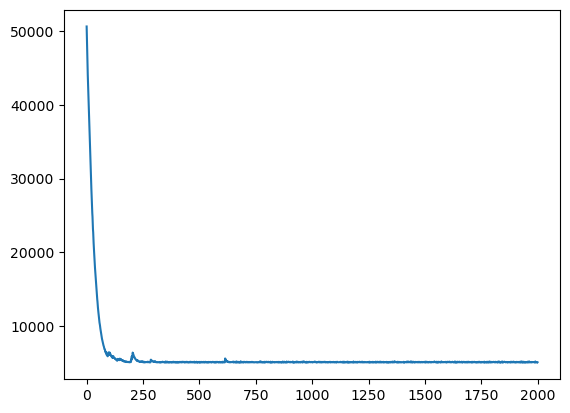

In [15]:
plt.plot(losses);

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

In [16]:
pas = torch.tensor(df['Passengers'].values)

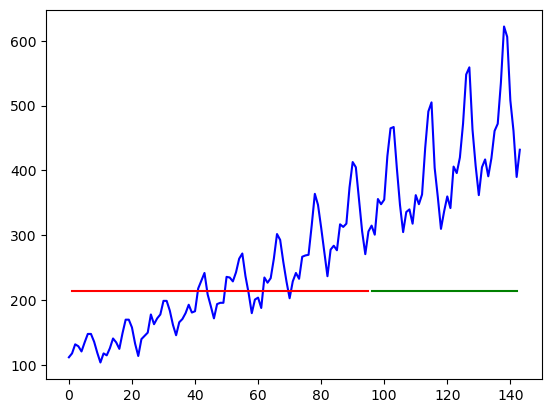

In [17]:
def plot_predicts(model, X_train, X_test, timeseries, lookback):
  train_size = len(X_train)
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:lookback+train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:train_size+lookback+len(X_test)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts(model, X_train, X_test, pas, lookback)

In [14]:

model.eval()
with torch.no_grad():
    preds = model(X_test).squeeze().numpy()
    print("Sample predictions:", preds[:10])
    print("Std of predictions:", np.std(preds))

Sample predictions: [214.61273 214.61273 214.61273 214.61273 214.61273 214.61273 214.61273
 214.61273 214.61273 214.61273]
Std of predictions: 4.5776367e-05


**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [18]:
model_1 = AirModel(input_size=1, hidden_size=100, num_layers=1)

In [19]:
losses_2 = train_model(model, train_dl, test_dl, optimizer, num_epochs=2000)

  0%|▏                                        | 10/2000 [00:00<00:40, 49.61it/s]

Epoch 0: train RMSE 71.1494, test RMSE 214.9220


  6%|██▏                                     | 111/2000 [00:01<00:33, 56.85it/s]

Epoch 100: train RMSE 71.1491, test RMSE 215.0822


 10%|████▏                                   | 210/2000 [00:03<00:29, 60.19it/s]

Epoch 200: train RMSE 71.1492, test RMSE 215.0004


 15%|██████▏                                 | 307/2000 [00:05<00:28, 59.25it/s]

Epoch 300: train RMSE 71.1491, test RMSE 215.1897


 20%|████████▏                               | 410/2000 [00:06<00:26, 59.76it/s]

Epoch 400: train RMSE 71.1494, test RMSE 214.9189


 26%|██████████▎                             | 513/2000 [00:08<00:24, 59.98it/s]

Epoch 500: train RMSE 71.1491, test RMSE 215.0273


 30%|████████████▏                           | 607/2000 [00:10<00:23, 59.26it/s]

Epoch 600: train RMSE 71.1492, test RMSE 214.9749


 35%|██████████████                          | 706/2000 [00:11<00:23, 54.69it/s]

Epoch 700: train RMSE 71.1492, test RMSE 214.9874


 40%|████████████████▏                       | 810/2000 [00:13<00:22, 53.62it/s]

Epoch 800: train RMSE 71.1501, test RMSE 214.7431


 46%|██████████████████▏                     | 911/2000 [00:15<00:18, 58.42it/s]

Epoch 900: train RMSE 71.1492, test RMSE 215.2144


 51%|███████████████████▋                   | 1011/2000 [00:17<00:19, 50.71it/s]

Epoch 1000: train RMSE 71.1492, test RMSE 214.9661


 55%|█████████████████████▌                 | 1107/2000 [00:19<00:18, 48.07it/s]

Epoch 1100: train RMSE 71.1491, test RMSE 215.1097


 60%|███████████████████████▌               | 1206/2000 [00:21<00:23, 34.12it/s]

Epoch 1200: train RMSE 71.1491, test RMSE 215.0485


 65%|█████████████████████████▍             | 1307/2000 [00:23<00:14, 47.49it/s]

Epoch 1300: train RMSE 71.1493, test RMSE 214.9552


 70%|███████████████████████████▍           | 1407/2000 [00:25<00:12, 47.13it/s]

Epoch 1400: train RMSE 71.1502, test RMSE 214.7268


 75%|█████████████████████████████▍         | 1508/2000 [00:27<00:10, 48.69it/s]

Epoch 1500: train RMSE 71.1492, test RMSE 215.1922


 80%|███████████████████████████████▎       | 1608/2000 [00:29<00:08, 47.49it/s]

Epoch 1600: train RMSE 71.1494, test RMSE 214.9133


 85%|█████████████████████████████████▎     | 1709/2000 [00:32<00:06, 47.55it/s]

Epoch 1700: train RMSE 71.1491, test RMSE 215.1550


 91%|███████████████████████████████████▎   | 1811/2000 [00:34<00:03, 49.31it/s]

Epoch 1800: train RMSE 71.1493, test RMSE 215.2627


 95%|█████████████████████████████████████▏ | 1906/2000 [00:36<00:02, 43.40it/s]

Epoch 1900: train RMSE 71.1491, test RMSE 215.1802



00%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 51.84it/s]

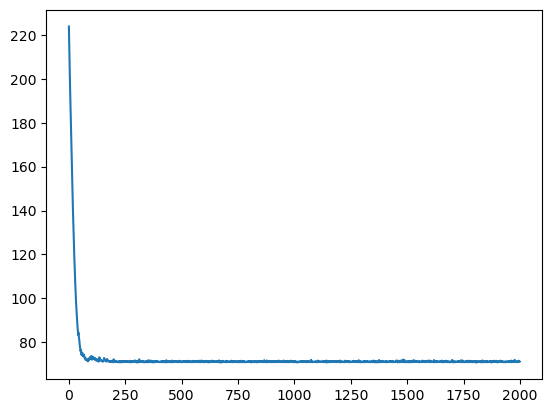

In [53]:
plt.plot(losses);

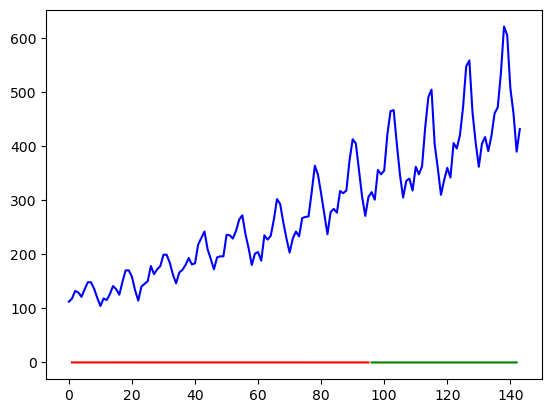

In [20]:


plot_predicts(model_1, X_train, X_test, pas, lookback)